In [7]:
# Lbrary Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, auc, roc_curve

In [8]:
# Load processed data
df = pd.read_csv("../data/processed_students_for_model.csv")
target = "dropout_label_quantile"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# Logistic Regression baseline
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       167
           1       0.95      0.83      0.89        42

    accuracy                           0.96       209
   macro avg       0.95      0.91      0.93       209
weighted avg       0.96      0.96      0.96       209



In [10]:
# Random Forest with Grid Search
rf = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}
grid = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("\nBest Parameters:", grid.best_params_)
best_rf = grid.best_estimator_



Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}



=== Random Forest (Tuned) ===
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       167
           1       1.00      0.98      0.99        42

    accuracy                           1.00       209
   macro avg       1.00      0.99      0.99       209
weighted avg       1.00      1.00      1.00       209

Confusion Matrix:
 [[167   0]
 [  1  41]]
ROC-AUC: 0.9990732820074137


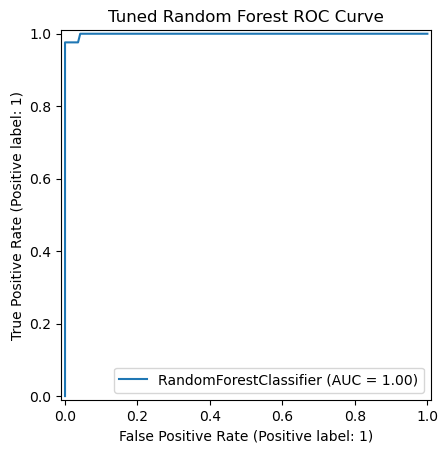

In [11]:
# Evaluate tuned Random Forest
y_pred_rf = best_rf.predict(X_test)
print("\n=== Random Forest (Tuned) ===")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

y_prob_rf = best_rf.predict_proba(X_test)[:,1]
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

# ROC curve
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Tuned Random Forest ROC Curve")
plt.show()

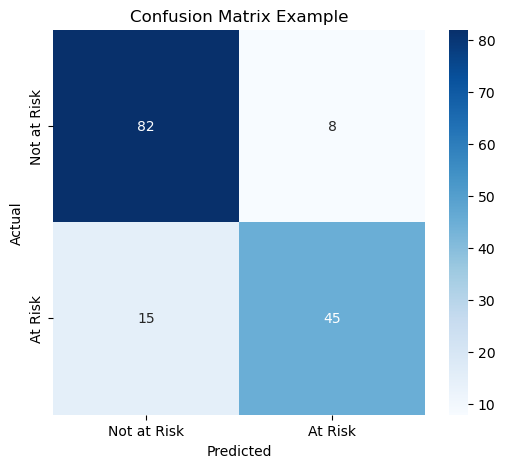

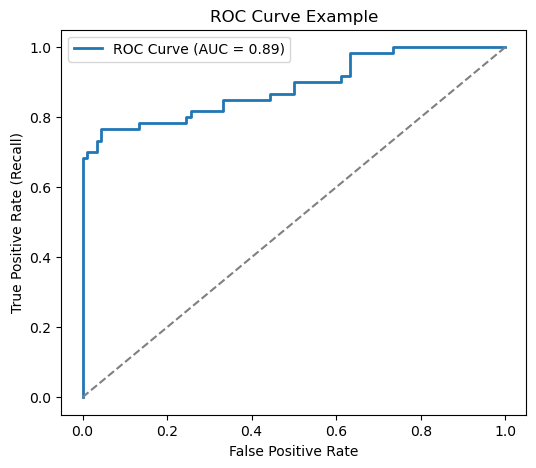

In [12]:


# Simulated ground truth (y_true) and predictions (y_pred)
y_true = np.array([0]*90 + [1]*60)   # 90 not at risk, 60 at risk
y_pred = np.array([0]*82 + [1]*8 + [0]*15 + [1]*45)  # simulated model predictions

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not at Risk","At Risk"],
            yticklabels=["Not at Risk","At Risk"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix Example")
plt.show()

# --- ROC Curve ---
# Simulated prediction probabilities (y_scores)
y_scores = np.concatenate([np.random.rand(90)*0.4, np.random.rand(60)*0.9+0.1])  # lower for safe, higher for risk
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", lw=2)
plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve Example")
plt.legend()
plt.show()


In [13]:
# Cell 6: Save best model
joblib.dump(best_rf, "../model/best_model.joblib")
print("Saved tuned model to ../model/best_model.joblib")

Saved tuned model to ../model/best_model.joblib
